# Purpose:

2015-02-19 (Thursday)

Use `pyMC` to model the distribution of $r^2$ at a specific distance bin to estimate the $\lambda$ parameter and allow us to assess the probabilities of $r^2$ values at the extremities of the distributions.

# Process outline:

1. model the bin distribution as an exponetial random variable $B$ with rate parameter $\lambda > 0$.
2. model $\lambda$ as a gamma random variable $L$ with initial parameters set to yield the mean at the value predicted to be the $\lambda$ based on the fact that the median of an exponetial dist = $\frac{\ln(2)}{\lambda}$

# Implementation:

## Imports:

In [2]:
# plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import ggplot as gp

In [3]:
import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy as sci
from scipy.stats import beta
from scikits import bootstrap as bs
import statsmodels.api as sm

import munch

import pymc as mc

# Build Model 

In [4]:
# bin_dist = mc.Exponential(name="bin_dist", beta=, value=None, observed=False

In [5]:
# lambda_dist = mc.Gamma?

In [6]:
# lambda_dist = mc.Gamma

In [7]:
# lambda_dist = mc.Gamma(name="lambda_dist", alpha=9, beta=1/0.5)

In [8]:
# bin_dist = mc.Exponential

In [9]:
smad = sm.robust.mad

## File paths:

In [10]:
# define paths to files
ld_table = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/SNPs/plink_out/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.maf0_05.vcf/ld/r_none_freqs_dprime.ld"


In [11]:
ld = pd.read_table(ld_table, sep=" +")
ld['R2'] = ld.R**2
ld['BP_DELTA'] = abs(ld.BP_A - ld.BP_B)

/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/io/parsers.py:639: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [12]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156


# Functions based on `2015-01-28_Plot_PLINK_results_cumulative.ipynb`

In [13]:
def get_snps_with_same_distance(df, d, win=100):
    lbound = d - win
    rbound = d + win
    
    if lbound < 0:
        lbound = 0
    
    return df[(df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)]

In [14]:
def get_snps_grouped_by_distances(df, ds, win=100):
    assert isinstance(ds, list)
    assert all([isinstance(d, int) for d in ds])
    
    groups = {}
    
    for d in ds:
        groups[d] = get_snps_with_same_distance(df=df, d=d, win=win)
        
    return groups

In [15]:
def collect_window_stat(df, upper_lim=1000, win=10,
                        stat_name="window_mean_r2", stat_func=np.mean,
                        return_df=True
                       ):
    
    
    data = {stat_name: [], 
            'd': np.array(range(upper_lim))+1}

    
    for d  in data['d']:
        data[stat_name].append(stat_func(get_snps_with_same_distance(df=df, d=d-1, win=win).R2))

    if return_df:
        return pd.DataFrame(data)
    else:
        return data

# Explore data a bit more

In [16]:
snps = get_snps_with_same_distance(df=ld, d=1000, win=0)
snps.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
157887,Scaffold48,467632,.,0.076923,Scaffold48,468632,.,0.103774,-0.099281,1.000000,0.009857,1000
184881,Scaffold117,281622,.,0.405660,Scaffold117,282622,.,0.414894,0.708485,0.740488,0.501951,1000
220859,Scaffold334,125425,.,0.075472,Scaffold334,126425,.,0.117647,-0.106525,1.000000,0.011348,1000
258721,Scaffold1,1713984,.,0.100000,Scaffold1,1714984,.,0.396226,-0.304911,1.000000,0.092971,1000
265848,Scaffold3,2182147,.,0.490566,Scaffold3,2183147,.,0.229167,0.021497,0.038612,0.000462,1000


In [17]:
len(snps)

19

## How many members does each distance group have?

In [18]:
members_per_distance = collect_window_stat(df=ld, upper_lim=1000, win=1,
                                           stat_name="window_members", stat_func=len)

In [19]:
members_per_distance.head()

,d,window_members
0,1,2091
1,2,3631
2,3,5056
3,4,4241
4,5,4040


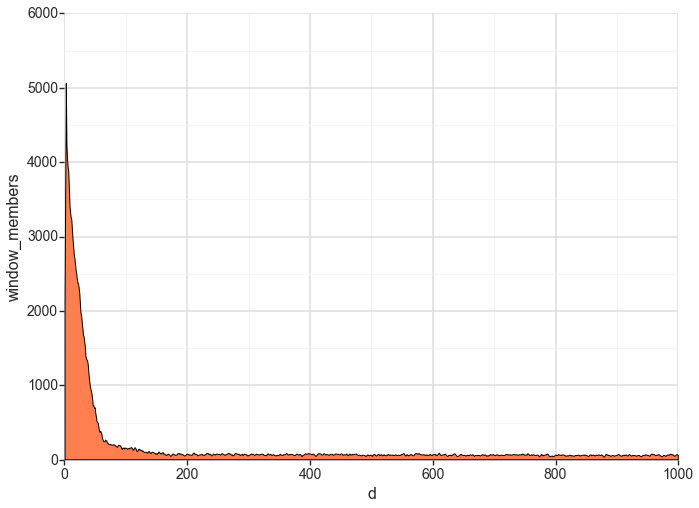

<ggplot: (8782528656569)>

In [20]:
gp.ggplot(gp.aes(x='d', y='window_members', ymin=0, ymax='window_members'), data=members_per_distance) \
+ gp.geom_area(fill='coral') + gp.theme_seaborn(context='talk')

In [21]:
# def bootstrap_choose(X, n=None):
#     """ Bootstrap resample an array_like
#     Parameters
#     ----------
#     X : array_like
#       data to resample
#     n : int, optional
#       length of resampled array, equal to len(X) if n==None
#     Results
#     -------
#     returns X_choices
#     """
#     if n == None:
#         n = len(X)
        
#     choice_i = np.floor(np.random.rand(n)*len(X)).astype(int)
#     X_choices = X[choice_i]
#     return X_choices

# def get_bootstrap_population(X, n=None):
#     pass

def bootstrap_resample(data, num_samples, sample_size=None):
    """Returns bootstrap resample distributions."""
    if sample_size is None:
        sample_size = len(data)
    else:
        assert isinstance(sample_size,int)
        
    
    samples = []
    
    for x in range(num_samples):
        samples.append(np.random.choice(data, size=sample_size))
    return samples
            


    

In [22]:
distance_list = [1,5,10,50,100,500,1000,5000,10000]

In [23]:
snp_groups_by_distance = get_snps_grouped_by_distances(df=ld, ds=distance_list, win=1)

In [24]:
snp_groups_by_distance[10000].BP_DELTA.head()

8012      9999
55896    10000
60879     9999
78750     9999
81524    10000
Name: BP_DELTA, dtype: int64

# How do bootstrap confidence intervals change as distance increases and member numbers decrease?

In [25]:
def get_med_mad_R2_data_for_1_group(df, distance):
    med = munch.Munch()
    mad = munch.Munch()
    
    med.distance = distance
    mad.distance = distance
    
    med.center_type = 'median'
    mad.center_type = 'mad'
    
    med.center = df.R2.median()
    mad.center = sm.robust.mad(df.R2)
    
    med.snp_pairs = len(df.R2)
    mad.snp_pairs = len(df.R2)
    
    med.ci_low, med.ci_high = bs.ci(data=df.R2,
                                    statfunction=np.median,
                                    alpha=0.05,
                                    n_samples=10000,
                                    method='bca',
                                    output='lowhigh'
                                   )

    mad.ci_low, mad.ci_high = bs.ci(data=df.R2, 
                                    statfunction=sm.robust.mad, 
                                    alpha=0.05, 
                                    n_samples=10000, 
                                    method='bca', 
                                    output='lowhigh'
                                   )


    return pd.Series(med), pd.Series(mad)

In [26]:
bootstrap_results_template = \
"""
DISTANCE: {dist}

MEDIAN: {median}
CI: {median_low_ci},{median_hi_ci}
RANGE(MEDIAN): {median_range}

MAD: {mad}
CI: {mad_low_ci},{mad_hi_ci}
RANGE(MAD): {mad_range}
"""

In [27]:
# mm_data = get_med_mad_R2_data_for_1_group(df=snp_groups_by_distance[1],
#                                           distance=1)

# print bootstrap_results_template.format(dist=mm_data[0].distance,
#                                         median=mm_data[0].center,
#                                         median_low_ci=mm_data[0].ci_low,
#                                         median_hi_ci=mm_data[0].ci_high,
#                                         median_range=mm_data[0].ci_high - mm_data[0].ci_low,
                                        
#                                         mad=mm_data[1].center,
#                                         mad_low_ci=mm_data[1].ci_low,
#                                         mad_hi_ci=mm_data[1].ci_high,
#                                         mad_range=mm_data[1].ci_high - mm_data[1].ci_low
#                                        )

In [28]:
# print mm_data

In [29]:
# mm_df = pd.Series(mm_data)
# mm_df

In [30]:
def collect_bootstraps_for_dict(named_distribution_vectors, num_samples):
    
    assert isinstance(named_distribution_vectors, dict)
    assert isinstance(num_samples, int)
    
    bs_dists = {}
    
    for key in named_distribution_vectors.keys():
            bs_dists[key] = bootstrap_resample(data=named_distribution_vectors[key],
                                                    num_samples=num_samples,
                                                    sample_size=None
                                               )
    
    return bs_dists

## Plot how the CIs for median and MAD change with distance

- x-axis: $d$ (distance)
- y-axis: $r^2$ (LD)

1. Convert `mm_data` to `Dataframe` and use the column headers to plot to lines with upper/lower shaded bounds.
2. `ggplot` with two line geoms and correponding fill geoms.

In [31]:
# center_pairs = [get_med_mad_R2_data_for_1_group(df=snp_groups_by_distance[d],
#                                                 distance=d) for d in distance_list
#                 ]

In [32]:
# centers_v_d = pd.DataFrame(list(it.chain.from_iterable(center_pairs)))

In [33]:
# centers_v_d

In [34]:
# dvc = gp.ggplot(gp.aes(x='distance', y='center',
#                        ymin="ci_low", ymax="ci_high",
#                        color='center_type', fill='center_type'
#                       ), 
#                 data=centers_v_d) \
# + gp.scale_color_brewer(type='qual') \
# + gp.theme_seaborn(context='talk') 

# p = dvc + gp.geom_area(alpha=0.3) \
# + gp.geom_line(alpha=1) \
# + gp.scale_x_log10()


# print p;



## Plot how the CIs for median and MAD change with membership (number of snp pairs)




In [35]:
# dvc = gp.ggplot(gp.aes(x='snp_pairs', y='center',
#                        ymin="ci_low", ymax="ci_high",
#                        color='center_type', fill='center_type'
#                       ), 
#                 data=centers_v_d) \
# + gp.scale_color_brewer(type='qual') \
# + gp.theme_seaborn(context='talk') 

# p = dvc + gp.geom_area(alpha=0.3) \
# + gp.geom_line(alpha=1) \
# # + gp.scale_x_log10()


# print p;



In [36]:
d1 = snp_groups_by_distance[1]
d1.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
126,Scaffold0,111960,.,0.094340,Scaffold0,111961,.,0.198113,0.129084,0.198797,0.016663,1
387,Scaffold0,425425,.,0.320755,Scaffold0,425427,.,0.320755,1.000000,1.000000,1.000000,2
1242,Scaffold0,1379579,.,0.094340,Scaffold0,1379580,.,0.330189,0.459684,1.000000,0.211309,1
1386,Scaffold0,1483974,.,0.198113,Scaffold0,1483975,.,0.235849,0.894690,1.000000,0.800470,1
1413,Scaffold0,1508310,.,0.103774,Scaffold0,1508311,.,0.103774,-0.038305,0.330813,0.001467,1


In [37]:
snp_groups_by_distance[1].BP_DELTA.skew()

0.30718053383413518

In [38]:
bs_per_distance = collect_bootstraps_for_dict(named_distribution_vectors={i:snp_groups_by_distance[i].R2 for i in snp_groups_by_distance.keys()},
                                              num_samples=200)

In [39]:
len(bs_per_distance.values()[0])

200

In [40]:
df_bs_per_distance = pd.DataFrame(bs_per_distance)
df_bs_per_distance.head()

,1,5,10,50,100,500,1000,5000,10000
0,"[0.134394093604, 1.0, 0.015151394281, 1.0, 1.0...","[0.141700297761, 0.014958268416, 1.0, 0.485714...","[1.0, 0.321821347849, 0.311688840681, 0.293333...","[0.790322778001, 0.774859428121, 0.83122971152...","[0.023008035856, 0.166666429504, 0.03614447368...","[0.338460987076, 0.590747497201, 0.79366182912...","[0.643808850129, 0.056667326401, 0.01908625140...","[0.010187066761, 0.044951632324, 0.0483648064,...","[0.028592442649, 0.039844551321, 0.01012539062..."
1,"[0.017224987536, 0.939081159844, 1.0, 0.017241...","[1.0, 0.016697549961, 1.0, 0.600000512409, 0.0...","[0.60933636, 0.936601999524, 1.0, 0.5197097862...","[0.018500352256, 5.40720503569e-05, 0.01246639...","[0.016867515625, 0.027009279025, 0.08663485824...","[0.793661829129, 0.00913043314089, 0.410801519...","[0.9178981249, 0.032410080784, 0.088318924225,...","[0.029221851136, 0.032610581056, 0.04642775184...","[0.015416450569, 0.009735176889, 0.1392857041,..."
2,"[1.0, 1.0, 0.866349546841, 1.0, 0.629370902241...","[0.049853511841, 0.822743330704, 1.0, 0.014328...","[2.86282782916e-05, 0.587301518736, 0.07335918...","[0.900557346529, 0.00849836921956, 0.009883779...","[0.0822312976, 0.237322916964, 0.022621062409,...","[0.410801519844, 0.00254787705225, 0.753189658...","[0.021902520025, 0.191010954304, 0.08027192232...","[0.00575637829264, 0.046427751841, 0.001194531...","[0.0301751641, 0.013901824836, 0.541220648329,..."
3,"[0.018003198976, 0.043773845284, 0.11821700592...","[0.952132947529, 0.962412012676, 1.0, 1.0, 0.8...","[0.026810132644, 0.502949037721, 0.01146077302...","[0.056689229025, 0.178284084169, 0.27211663590...","[0.055268718649, 1.0, 0.171355430401, 0.336538...","[0.150645673161, 1.0, 0.410801519844, 0.038773...","[0.011347575625, 0.032410080784, 0.01549054052...","[0.086574235225, 0.282878250769, 0.02039726676...","[0.063648730369, 0.128888898121, 0.00182695550..."
4,"[1.0, 1.0, 0.600136849225, 0.00653594636304, 1...","[0.00024293586496, 1.0, 0.319149294489, 0.0505...","[0.00930289185225, 0.175824230596, 0.071339204...","[0.059098096201, 0.082321364889, 0.01030935622...","[0.007597911556, 0.025304537476, 0.02857147896...","[0.00666389770929, 0.038773941921, 0.399386080...","[0.059098096201, 0.00985663753636, 0.349247904...","[7.1379274561e-06, 0.856998250564, 0.856998250...","[0.027545377024, 0.232558311049, 0.13189390158..."


In [41]:
x = df_bs_per_distance[1]

In [42]:
x.apply(smad)

0     0.432734
1     0.350433
2     0.387602
3     0.387757
4     0.304173
5     0.387757
6     0.363576
7     0.363576
8     0.399771
9     0.475897
10    0.441961
11    0.399771
12    0.415755
13    0.372074
14    0.387602
...
185    0.441961
186    0.319858
187    0.387997
188    0.447399
189    0.387125
190    0.306945
191    0.354487
192    0.352756
193    0.381017
194    0.324703
195    0.387757
196    0.281580
197    0.342519
198    0.390670
199    0.377851
Name: 1, Length: 200, dtype: float64

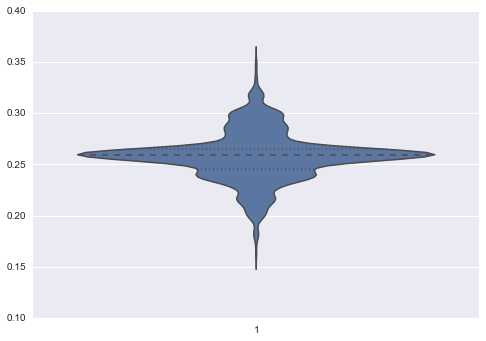

In [43]:
sns.violinplot(sm.robust.mad(bootstrap_resample(d1.R2,10000),1))

-------------

# Implement the modified z-score


Modified z-score ($M_i$) defintion:

$$M_i = \frac{0.6745(x_i-\tilde{x})}{\mathrm{MAD}}$$

Where:

- $x_i$ is the $i^\mathrm{th}$ observation 
- $\tilde{x}$ is the median of the observations
- $\mathrm{MAD}$ is the median absolute deviation.


In [44]:
def modified_z_scores(observations):
    
    M_i = (observations - np.median(observations)) / smad(observations)
    
    return M_i
    

In [45]:
snp_groups_by_distance 
# add column for distance group and concat dfs rather than keeping them in a dict
dfs = []
for k, v in snp_groups_by_distance.iteritems():
    df = v.copy()
    df['distance_group'] = k
    df['modified_z'] = modified_z_scores(df.R2)
    dfs.append(df)
    
df_snp_groups_by_distance = pd.concat(dfs)

In [46]:
df_snp_groups_by_distance.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_group,modified_z
126,Scaffold0,111960,.,0.094340,Scaffold0,111961,.,0.198113,0.129084,0.198797,0.016663,1,1,-1.892288
387,Scaffold0,425425,.,0.320755,Scaffold0,425427,.,0.320755,1.000000,1.000000,1.000000,2,1,0.674490
1242,Scaffold0,1379579,.,0.094340,Scaffold0,1379580,.,0.330189,0.459684,1.000000,0.211309,1,1,-1.384207
1386,Scaffold0,1483974,.,0.198113,Scaffold0,1483975,.,0.235849,0.894690,1.000000,0.800470,1,1,0.153663
1413,Scaffold0,1508310,.,0.103774,Scaffold0,1508311,.,0.103774,-0.038305,0.330813,0.001467,1,1,-1.931952


/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


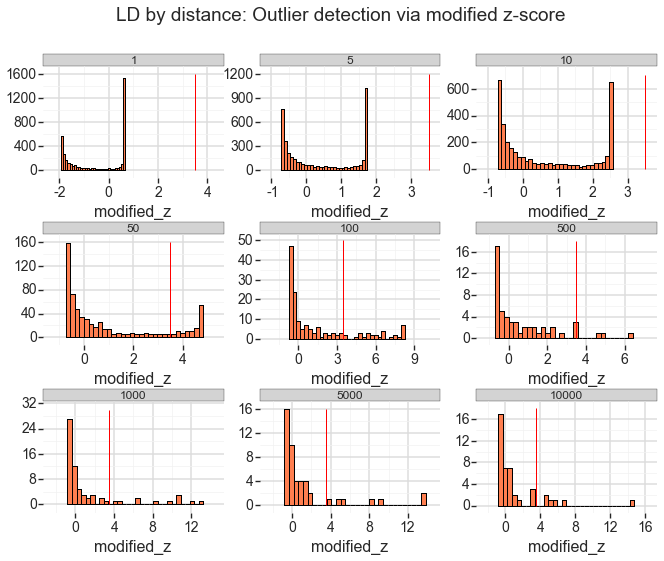

<ggplot: (8782485527361)>

In [47]:
p = gp.ggplot(gp.aes(x='modified_z'), data=df_snp_groups_by_distance)
p + gp.geom_histogram(fill='coral')  + gp.geom_vline(xintercept=[3.5], color='red') + \
    gp.facet_wrap("distance_group") + \
    gp.ggtitle("LD by distance: Outlier detection via modified z-score") + \
    gp.theme_seaborn(context='talk')
    


# Implement non-overlapping bins for z-scores


In [48]:
range(0,100,10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [49]:
def get_snps_in_bin_mask(df, d, win=100):
    
    lbound = d
    rbound = d + win

    return (df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)


def update_distance_bin(df, win=100):

    assert isinstance(df, pd.DataFrame)

    # get bin definitions
    longest_d = df.BP_DELTA.max()  # teehee

    ds = xrange(0, longest_d, win)

    # add/overwrite distance_bin column 
    df['distance_bin'] = -1
    df['distance_bin_mean_R2'] = -1
    df['distance_bin_median_R2'] = -1
    
    for d in ds:
        bin_mask = get_snps_in_bin_mask(df=df, d=d, win=win)
        df.loc[bin_mask, 'distance_bin'] = d
        df.loc[bin_mask, 'distance_bin_mean_R2'] = df[bin_mask].R2.mean()
        df.loc[bin_mask, 'distance_bin_median_R2'] = df[bin_mask].R2.median()
    
    # sanity check
    assert df['distance_bin'].min() >= 0
    assert df['distance_bin_mean_R2'].min() >= 0
    assert df['distance_bin_median_R2'].min() >= 0

In [50]:
def update_mad_z(df):
    assert isinstance(df, pd.DataFrame)
    
    # add/overwrite mad_z column 
    df['mad_z'] = 'loco'
    
    for d in df.distance_bin.unique():
        d_mask = df.distance_bin == d
        df.loc[d_mask, 'mad_z'] = modified_z_scores(df.R2[d_mask])
        
    # sanity check
    assert 'loco' not in df.mad_z

In [51]:
d100 = df_snp_groups_by_distance[df_snp_groups_by_distance.distance_group == 100]

In [52]:
d100.R2.median()

0.083177829682

In [53]:
def hist_of_bin(df):
    p = gp.ggplot(gp.aes(x='R2'), data=df)
    p + gp.geom_histogram(fill='coral')  + \
        gp.theme_seaborn(context='talk')
    return p

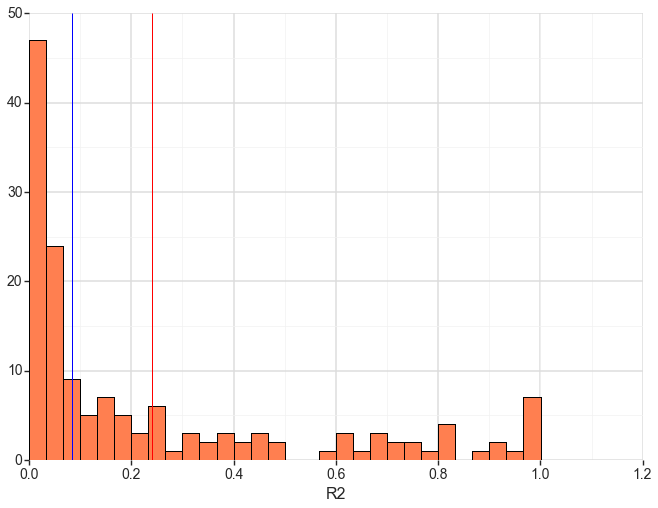

<ggplot: (8782475430353)>

In [54]:
df=d100

p = gp.ggplot(gp.aes(x='R2'), data=df)
p + gp.geom_histogram(fill='coral')  + \
    gp.geom_vline(xintercept=[df.R2.mean()], color='red') + \
    gp.geom_vline(xintercept=[df.R2.median()], color='blue') + \
    gp.theme_seaborn(context='talk')


# Build the model using d100 bin ($r^2 = \mathrm{Exponential}(x)$)

In [55]:
def estimate_lambda_from_median_data(df):
    return np.log(2)/df.R2.median()

In [56]:
lambda_data = estimate_lambda_from_median_data(d100)
lambda_data

8.3333165004417626

In [57]:
lambda_dist = mc.Normal(name="lambda_dist", mu=lambda_data, tau=50)

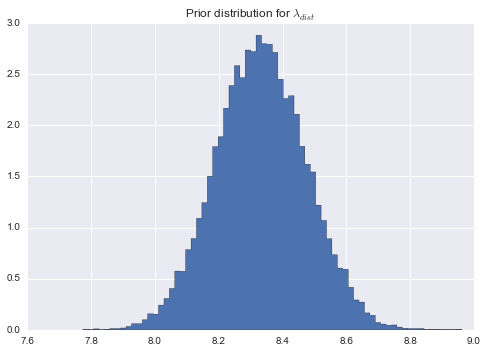

In [58]:
samples = [lambda_dist.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_{dist}$")


In [59]:
observations = mc.Exponential(name="observations", beta=lambda_dist, value=d100.R2, observed=True)
# observations.stats()

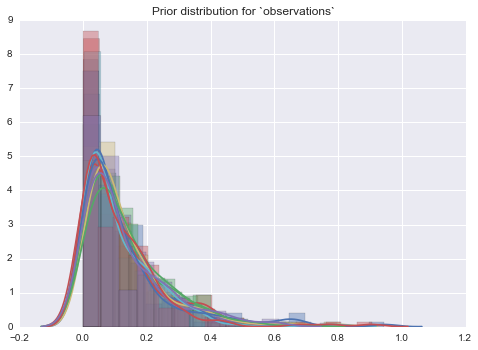

In [60]:
samples_obs = [observations.random() for i in range(1000)]
[sns.distplot(samples_obs[i]) for i in range(10)]

# plt.hist(samples_obs, bins=70, normed=True, histtype="stepfilled", alpha=0.1)
plt.title("Prior distribution for `observations`")


In [61]:
M = mc.Model([observations, lambda_dist])

In [62]:
mcmc = mc.MCMC(M)
map_ = mc.MAP(M)

In [63]:
map_.fit()

In [64]:
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 4.2 sec

In [65]:
bin_lambda_samples = mcmc.trace("lambda_dist")[:]

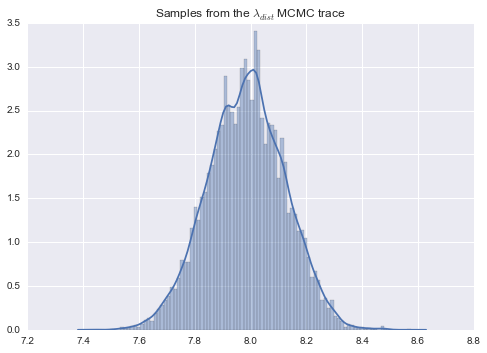

In [66]:
sns.distplot(bin_lambda_samples, );
plt.title('Samples from the $\lambda_{dist}$ MCMC trace');

In [67]:
mc.__version__

'2.3.4'

In [68]:
# graph.write_jpeg('/home/gus/tmp/model.jpg')

Plotting lambda_dist


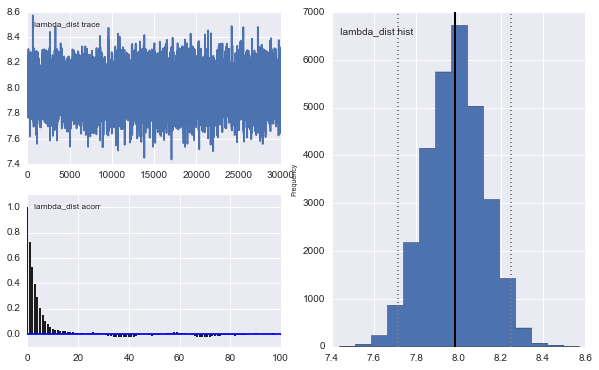

In [69]:
mc.Matplot.plot(mcmc)

# Build the model using d100 bin ($r^2 = \mathrm{Beta}(x)$)

In [70]:
# func to plot the beta prob density function

def plt_beta(a,b):
    x = np.linspace(beta.ppf(0.01, a, b),
                  beta.ppf(0.99, a, b), 1000)
    plt.plot(x, beta.pdf(x, a, b),
             'r-', lw=2, alpha=0.6, label='beta pdf')

In [71]:
# generate some simulated beta data for testing our model
rv_a,rv_b = (0.6,.8)

rv = beta(rv_a,rv_b)

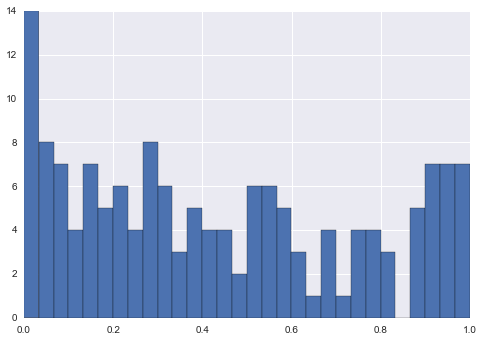

In [72]:
test_data = rv.rvs(len(d100.R2))
plt.hist(test_data,
         bins=30);

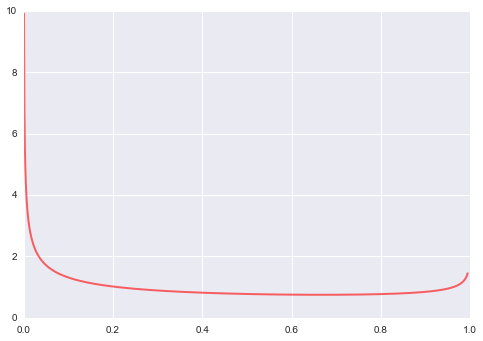

In [73]:
plt_beta(rv_a,rv_b)

In [74]:
# df=d100

# p = gp.ggplot(gp.aes(x='R2'), data=df)
# p + gp.geom_histogram(fill='coral')  + \
#     gp.geom_vline(xintercept=[df.R2.mean()], color='red') + \
#     gp.geom_vline(xintercept=[df.R2.median()], color='blue') + \
#     gp.theme_seaborn(context='talk')

In [110]:
b_alpha = mc.Uniform('b_alpha',0.01,10)
b_beta = mc.Uniform('b_beta',0.01,10)


In [111]:
# pdb

In [112]:
process = mc.Beta(name='process',
                      alpha=b_alpha,
                      beta=b_beta,
                      value=test_data,
                      observed=True,
                      verbose=0
                     )

In [113]:
LD_bin = mc.Model([process, b_alpha, b_beta])

In [114]:
b_alpha.value, b_beta.value

(array(1.5490388931840091), array(1.7198941369077425))

In [115]:
map_ld = mc.MAP(LD_bin)
map_ld.fit()

In [116]:
print b_alpha.value, b_beta.value

0.639721378549 0.795449842385


In [117]:
mcmc_ld = mc.MCMC(LD_bin)

In [118]:
mcmc_ld.sample(iter=40000, burn=20000, thin=5)

 [-----------------100%-----------------] 40000 of 40000 complete in 9.8 sec

In [119]:
print b_alpha.value, b_beta.value

0.642434410804 0.725714752718


In [122]:
%matplotlib inline

Plotting b_alpha
Plotting b_beta


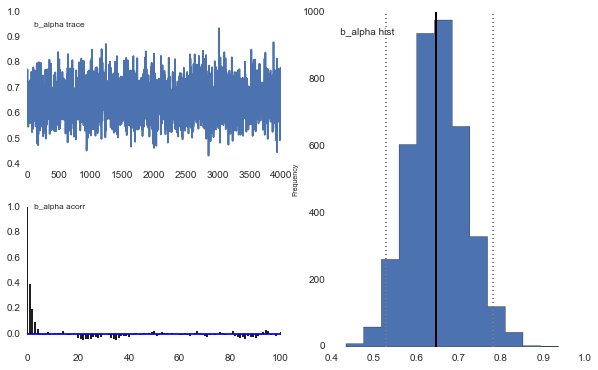

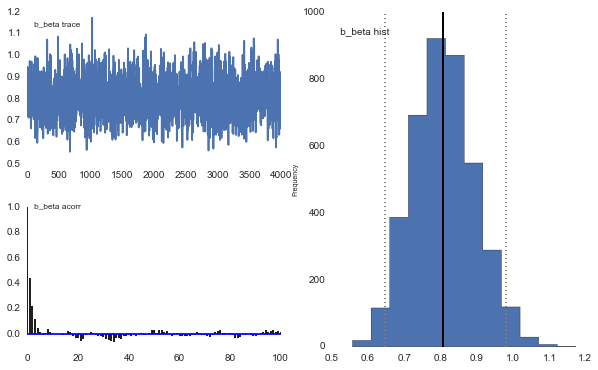

In [123]:
x = mc.Matplot.plot(mcmc_ld)

In [ ]:
%matplotlib inline

In [ ]:
print rv_a,rv_b
plt_beta(rv_a,rv_b)

In [ ]:
print b_alpha.value, b_beta.value
plt_beta(b_alpha.value, b_beta.value)